<a href="https://colab.research.google.com/github/garyguzz0/numerical/blob/codes/Recurrent_NN_for_Language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Math 686: Deep Learning
#Project 3: Recurrent Neural Network
####Gary Guzzo
####Cornwell
---
Let us set up a few things before we begin.

In [ ]:
'''
Importing needed packages here
'''
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers

from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
import nltk
import collections
import itertools

import os
import tarfile
from functools import reduce

import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#@title Set up data: Part 1 (Author: Cornwell) - Run All Collapsed Cells
def tokenize(s):
    '''
    argument: string
    returns tokenized string (list of words)
    '''
    return nltk.tokenize.word_tokenize(s)
 
def parse_stories(lines):
    '''
    - Parse stories provided in the bAbI tasks format
    - A story goes from line 1 to line 15. Every 3 lines,
      a question & answer.
    - Extracts sub-stories within a story and
      returns tuples (story, question, answer)
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        new, line = line.split(' ', 1)
        new = int(new)
        if new == 1:
            # reset story when line ID=1 (start of new story)
            story = []
        if '\t' in line:
            # this line is tab separated Q, A &amp; support fact ID
            q, a, supporting = line.split('\t')
            # tokenize the words of question
            q = tokenize(q)
            # Provide all the sub-stories till this question
            substory = [x for x in story if x]
            # A story ends and is appended to global story data-set
            data.append((substory, q, a))
            story.append('')
        else:
            # this line is a sentence of story
            sentence = tokenize(line)
            story.append(sentence)
    return data
 
def get_stories(f):
    '''
    argument: filename
    returns list of all stories in the argument data-set file
    '''
    # read the data file and parse stories
    data = parse_stories(f.readlines())
    # lambda func to flatten the list of sentences into one list
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    # creating list of tuples for each story
    data = [(flatten(story), query, answer) for story, query, answer in data]
    return data
#@title
nltk.download('punkt')
#@title
path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
tar = tarfile.open(path)
#@title
task = 'tasks_1-20_v1-2/en-10k/qa10_indefinite-knowledge_{}.txt'
print('Extracting stories for the task: indefinite_knowledge_1k')
# Store the stories for training
tr_stories = get_stories(tar.extractfile(task.format('train')))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
11755520/11745123 [==============================] - 0s 0us/step
Extracting stories for the task: indefinite_knowledge_1k


In [ ]:
'''------------------------------'''
'''Setup training/validation sets'''
'''------------------------------'''

#Author: Cornwell

validation_size = 1500
val_indices = np.random.choice(len(tr_stories), size=validation_size, replace=False)
val_stories = []
train_stories = []
for i in range(len(tr_stories)):
  if i in val_indices:
    val_stories.append(tr_stories[i])
  else:
    train_stories.append(tr_stories[i])

In [ ]:
#@title Set up the data: Part 2 (Author: Cornwell)
def numericize_stories(data, word_idx, story_maxlen, query_maxlen):
    # story indices initialization
    X = []
    # query indices initialization
    Xq = []
    # answer indices intialization
    Y = []
    for story, query, answer in data:
        # creating list of story word indices
        x = [word_idx[w] for w in story]
        # creating list of query word indices
        xq = [word_idx[w] for w in query]
        # let's not forget that index 0 is reserved
        ## y = np.zeros(len(word_idx) + 1)
        ## you would do the above if any word in the vocab was possible
        ## with the simple questions we have, everything has answer 'yes','no','maybe' ; see converter defined below
        y = np.zeros(3)
        # creating label 1 for the answer word index 
        # (the function answer_converter is defined later below: after noting that the only answers in this data set are 'maybe', 'no', and 'yes')
        y[answer_converter(word_idx[answer])] = 1
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    return (pad_sequences(X, maxlen=story_maxlen),
            pad_sequences(Xq, maxlen=query_maxlen), np.array(Y))
# creating vocabulary of words in train and validation set
vocab = set()
for story, q, answer in train_stories + val_stories:
    vocab |= set(story + q + [answer])

# sorting the vocabulary
vocab = sorted(vocab)
 
# Reserve 0 for masking in the embedding layers
vocab_size = len(vocab) + 1   ### !!!!!!!!! added 1 here
 
# calculate maximum length of story
story_maxlen = max(map(len, (x for x, _, _ in train_stories + val_stories)))
 
# calculate maximum length of question/query
query_maxlen = max(map(len, (x for _, x, _ in train_stories + val_stories)))
 
# creating word to index dictionary
word_idx = {c: i + 1 for (i, c) in enumerate(vocab)}
 
# creating index to word dictionary
idx_word = {i+1:c for (i,c) in enumerate(vocab)}
def answer_converter(index):
  if index == 16:
    return 0
  if index == 18:
    return 1
  if index == 27:
    return 2
def answer_idx_word(i):
  responses = ['maybe','no','yes']
  return responses[i]
# numericize train story, query and answer sentences/word using vocab
inputs_train, queries_train, answers_train = numericize_stories(train_stories,
                                                               word_idx,
                                                               story_maxlen,
                                                               query_maxlen)
# numericize validation story, query and answer sentences/word using vocab
inputs_val, queries_val, answers_val = numericize_stories(val_stories,
                                                               word_idx,
                                                               story_maxlen,
                                                               query_maxlen)

In [ ]:
'''Callbacks'''

#Save weights callback

checkpoint_path = '/content/gdrive/My Drive/Colab Notebooks/Final_Weights/Final_Project/DL_Final_explorer_weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Save model weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor = 'val_categorical_accuracy',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

#Obersvation
The data has a rather simple structure: stories concerning the whereabouts of different people, questions about someone's whereabouts, and an answer to the question. Each of the stories is very similar: (This person) + (Traveled in some manner) + (To some location). Sometimes, there will be an "either or" situation, (This person) + (Is either, or) + (At this location) + (At that location). Also, the word dictionary is very small, at 27 total words. With such a small dictionary, and such simple stories, questions, and answers, the words used will almost always be *meaningful*.

#Hypothesis
Since we are working with text data, we want to use an adaptive learning rate for the optimization of the model. The optimizer **AdaM** was chosen, but not with the default parameters. Since we want to make sure the words in the (very small) dictionary "hold their value", we will tweak the parameters of AdaM so that the algorithm will *explore more*. In other words, we want the gradient descent update vectors to take bigger steps in the parameter space (of weights), and to do so for more epochs. Also, if a word appears often, we don't necessarily want its contribution to the weights to diminish throughout training. So, the following parameters were tweaked:

####- Increase learning rate $\eta$ from the gradient update vector
####- Increase the dampen rates $\beta_1$ and $\beta_2$ from the moment estimations of the gradient
####- Decrease the term $\epsilon$ in the adaptive rate (the coefficient of previous update vector $m_t$) that prevents division by 0. This will keep the contribution to the weights from a word sizable for more epochs. 

#Experiment

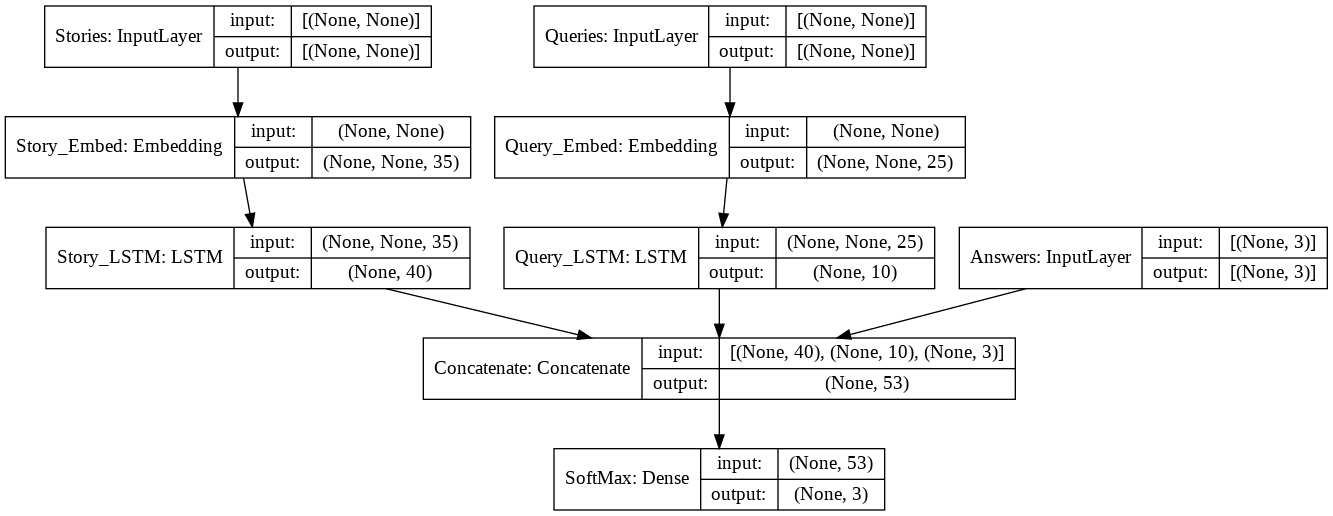

In [ ]:
''' ''' 
#setup variables for the shape of the data
batch=len(inputs_train)
timesteps=story_maxlen
feature=vocab_size

batch2=len(queries_train)
timesteps2=query_maxlen

'''-----------------------------------------'''
'''Begin building the model, layer by layer '''
'''-----------------------------------------'''

#Make the STORIES a Keras Input
api_input_stories=keras.Input(shape=(None,),name="Stories")

#Make the QUERIES a Keras Input
api_input_queries=keras.Input(shape=(None,),name="Queries")

#Make the ANSWERS a Keras Input
api_input_answers=keras.Input(shape=(3,),name="Answers")


'''Embedding Layers'''
#Embed each word in the STORY into a 35-dimensional vector
api_story_features=layers.Embedding(input_dim=vocab_size, input_length = timesteps, output_dim=35, trainable=True, mask_zero=True,name="Story_Embed")(api_input_stories)

#Embed each word in the QUERY into a 25-dimensional vector
api_query_features=layers.Embedding(input_dim=vocab_size, input_length = timesteps2, output_dim=25, trainable=True, mask_zero=True,name="Query_Embed")(api_input_queries)

#Already setup correct ANSWERS
api_answer_features=api_input_answers


'''LSTM Layers'''
#Reduce the sequence of embedded words in the story
api_story_features=layers.LSTM(40,return_sequences=False,bias_regularizer='l2',recurrent_activation='sigmoid',name="Story_LSTM")(api_story_features)

#Reduce the sequence of embedded words in the question
api_query_features=layers.LSTM(10,return_sequences=False,bias_regularizer='l2',recurrent_activation='sigmoid',name="Query_LSTM")(api_query_features)

'''--------------------'''
'''Connect the networks'''
'''--------------------'''

x=layers.concatenate([api_story_features,api_query_features,api_answer_features],name="Concatenate")

#Dense SoftMax Layer
api_answer_pred=layers.Dense(3,activation='softmax',name="SoftMax")(x)

'''----------------'''
'''Define the model'''
'''----------------'''

#This initial model will NOT use the fast_adam (the explorer)
api_model=keras.Model(
    inputs=[api_input_stories,api_input_queries,api_input_answers],
    outputs=[api_answer_pred]
    )

#Comiple the model
api_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])

#Show the model
keras.utils.plot_model(api_model, "my_first_model.png",show_shapes=True)

In [ ]:
'''---------------------'''
'''Train the default model'''
'''---------------------'''

#This model will use the DEFAULT AdaM parameters
api_history=api_model.fit(x=[inputs_train,queries_train,answers_train],y=answers_train,batch_size=150,verbose=1,epochs=3,validation_split=.1)

Epoch 1/3
51/51 [==============================] - 14s 154ms/step - loss: 1.7656 - categorical_accuracy: 0.0118 - val_loss: 1.6603 - val_categorical_accuracy: 0.0000e+00
Epoch 2/3
51/51 [==============================] - 5s 104ms/step - loss: 1.5654 - categorical_accuracy: 0.0703 - val_loss: 1.4861 - val_categorical_accuracy: 0.1376
Epoch 3/3
51/51 [==============================] - 5s 103ms/step - loss: 1.4271 - categorical_accuracy: 0.1979 - val_loss: 1.3714 - val_categorical_accuracy: 0.2400


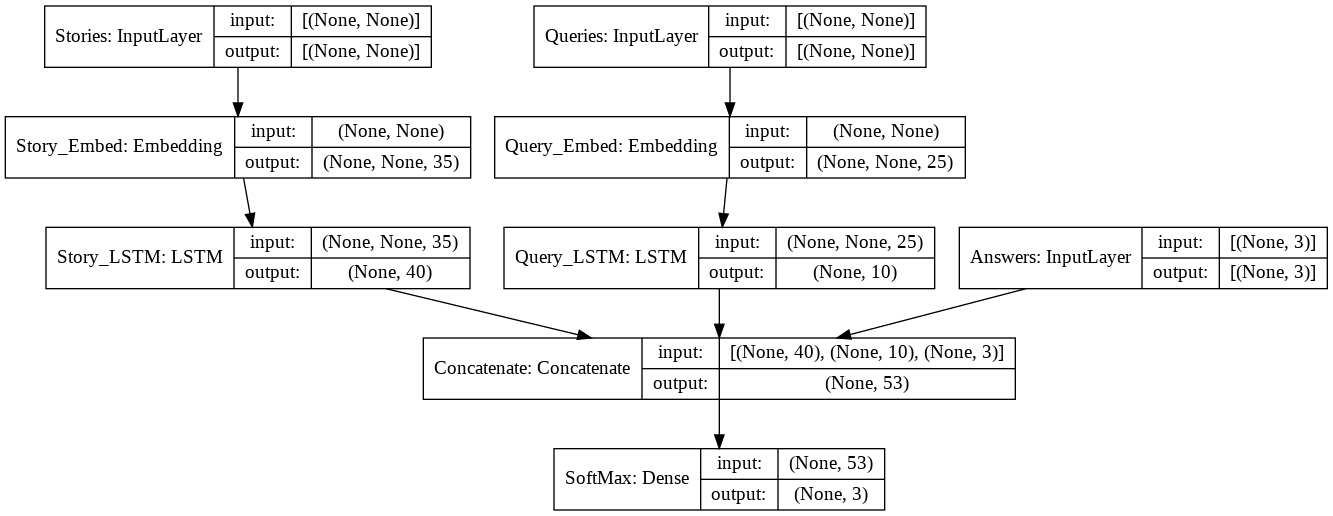

In [ ]:
'''---------------------------'''
'''Define "the explorer" model'''
'''---------------------------'''

#the explorer
fast_adam=tf.keras.optimizers.Adam( 
    learning_rate=0.015, #def .001
    beta_1=0.99, #def .9
    beta_2=0.9999, #def .999
    epsilon=1e-15, #def ...7
    amsgrad=False,
    name="Adam"
)


explorer_api_model=api_model        #the explorer
explorer_api_model.compile(optimizer=fast_adam,loss='categorical_crossentropy',metrics=['categorical_accuracy'])

#Show the model
keras.utils.plot_model(explorer_api_model, "my_second_model.png",show_shapes=True)

In [ ]:
'''------------------------'''
'''Train the explorer model'''
'''------------------------'''

explorer_api_history=explorer_api_model.fit(x=[inputs_train,queries_train,answers_train],y=answers_train,batch_size=150,verbose=1,epochs=4,validation_split=.1,callbacks=cp_callback)

Epoch 1/4
51/51 [==============================] - 14s 154ms/step - loss: 0.8352 - categorical_accuracy: 0.7733 - val_loss: 0.3800 - val_categorical_accuracy: 0.9929

Epoch 00001: val_categorical_accuracy improved from -inf to 0.99294, saving model to /content/gdrive/My Drive/Colab Notebooks/Final_Weights/Final_Project/DL_Final_explorer_weights.h5
Epoch 2/4
51/51 [==============================] - 5s 103ms/step - loss: 0.2348 - categorical_accuracy: 0.9953 - val_loss: 0.1574 - val_categorical_accuracy: 1.0000

Epoch 00002: val_categorical_accuracy improved from 0.99294 to 1.00000, saving model to /content/gdrive/My Drive/Colab Notebooks/Final_Weights/Final_Project/DL_Final_explorer_weights.h5
Epoch 3/4
51/51 [==============================] - 5s 101ms/step - loss: 0.1180 - categorical_accuracy: 1.0000 - val_loss: 0.0728 - val_categorical_accuracy: 1.0000

Epoch 00003: val_categorical_accuracy did not improve from 1.00000
Epoch 4/4
51/51 [==============================] - 5s 104ms/step 

In [ ]:
#@title Define accuracy (Author: Cornwell)

the_model = api_model
## Expected input for the_model, that can be used in the .predict method: a length 2 list of batches of the form [ inputs, queries ]
#                                                                                  3                             [ inputs, queries, answers ]

def predicted_idx(answer_word):
  return word_idx[answer_word]
def predicted_answer(sfmax_vector):
  return answer_idx_word(np.argmax(sfmax_vector))

## num_tests is the number of times you want to draw from the validation set and check accuracy
def approx_accuracy(num_tests):
  results = []
  for k in range(num_tests):
    i = np.random.randint(0,len(inputs_val))
    test_point = [inputs_val[i:i+1], queries_val[i:i+1],answers_val[i:i+1]] #input all 3
    results.append(
        predicted_answer(the_model.predict(test_point)[0]) == predicted_answer(answers_val[i])
    )
  return sum(results)/num_tests

In [ ]:
'''Test accuracy (over the course of n samples)'''
n=5
approx_accuracy(n)

1.0

#Results
From comparing three epochs of training on the standard model to the explorer model (the one that uses an explorative AdaM optimizer), we can accept the hypothesis. The accuracy achieved on the explorer model quickly reached 100 percent. The non-linear neural network (Functional API) we used also performed much better than a traditional linear sequential model, which was originally used for this experiment.

In [ ]:
explorer_api_model.save(checkpoint_path)

In [ ]:
'''Make sure the saved model works'''
reconstructed_model=keras.models.load_model(checkpoint_path)
reconstructed_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Stories (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
Queries (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
Story_Embed (Embedding)         (None, None, 35)     980         Stories[0][0]                    
__________________________________________________________________________________________________
Query_Embed (Embedding)         (None, None, 25)     700         Queries[0][0]                    
______________________________________________________________________________________________

In [ ]:
#@title Define accuracy again, so that we can test it on the saved model (Author: Cornwell)

the_model = explorer_api_model
## Expected input for the_model, that can be used in the .predict method: a length 2 list of batches of the form [ inputs, queries ]
#                                                                                  3                             [ inputs, queries, answers ]

def predicted_idx(answer_word):
  return word_idx[answer_word]
def predicted_answer(sfmax_vector):
  return answer_idx_word(np.argmax(sfmax_vector))

## num_tests is the number of times you want to draw from the validation set and check accuracy
def approx_accuracy(num_tests):
  results = []
  for k in range(num_tests):
    i = np.random.randint(0,len(inputs_val))
    test_point = [inputs_val[i:i+1], queries_val[i:i+1],answers_val[i:i+1]] #input all 3
    results.append(
        predicted_answer(the_model.predict(test_point)[0]) == predicted_answer(answers_val[i])
    )
  return sum(results)/num_tests

In [ ]:
'''Test accuracy (over the course of n samples)'''
n=5
approx_accuracy(n)

1.0

#Conclusion
Now that we have seen the results of using a non-linear neural network, which connects multiple neural networls into one, we can conclude that the hypothesis was supported, and the justifications were valid. As noted, the dictionary was small, the sentence formats were simple, and most of the words were important. Also because of these things, the neural network did not need many layers or nodes to perform well on the data.

#Remark
In the early stages of this experiment, a linear neural network was used, and the (Story), (Question), and (Answer) values were concatenated into (Story, Question, Answer). With a default AdaM optimizer on this architecture, 50 percent accuracy was not reached. After tweaking the optimizer (definining fast_adam (the explorer)), 51 percent accuracy was achieved. Small tweaks thereafter reached about 99 percent accuracy and 62 percent training accuracy after about 50 epochs. It was not until using both *an explorative optimizer* **and** *a non-linear network did we see exteremly high results in only a few epochs. 